# MATRIXS REQUIRED TO DISPLAY

1. Each and every model with hyperparameter tuning (learning rate).

2. Validation loss curve, Training loss curve, Validation accuracy curve

3. Model training performance matrices (precision, recall, and F1 score)

4. Model testing performance matrices (precision, recall, and F1 score)

5. Number of epochs model trained on.

6. Dataset Before and After Augmentation.

7. Testing Confusion matrix.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets
from PIL import Image
import os
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
import zipfile

import torch.nn.functional as F
from rich.console import Console
from rich.progress import Progress, BarColumn, TimeElapsedColumn, TimeRemainingColumn
from rich.table import Table

import pandas as pd
from torch.cuda.amp import autocast, GradScaler


from sklearn.metrics import precision_score, recall_score, f1_score, multilabel_confusion_matrix
import seaborn as sns
import numpy as np

In [2]:
# Install Git in case it's not available in your environment
!apt-get install git

# Clone the repository from GitHub
!git clone https://github.com/Samin1362/MerakiNexus-V2.git

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.14).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
Cloning into 'MerakiNexus-V2'...
remote: Enumerating objects: 6518, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 6518 (delta 11), reused 20 (delta 5), pack-reused 6479 (from 2)
Receiving objects: 100% (6518/6518), 1.93 GiB | 16.36 MiB/s, done.
Resolving deltas: 100% (150/150), done.
Updating files: 100% (6237/6237), done.


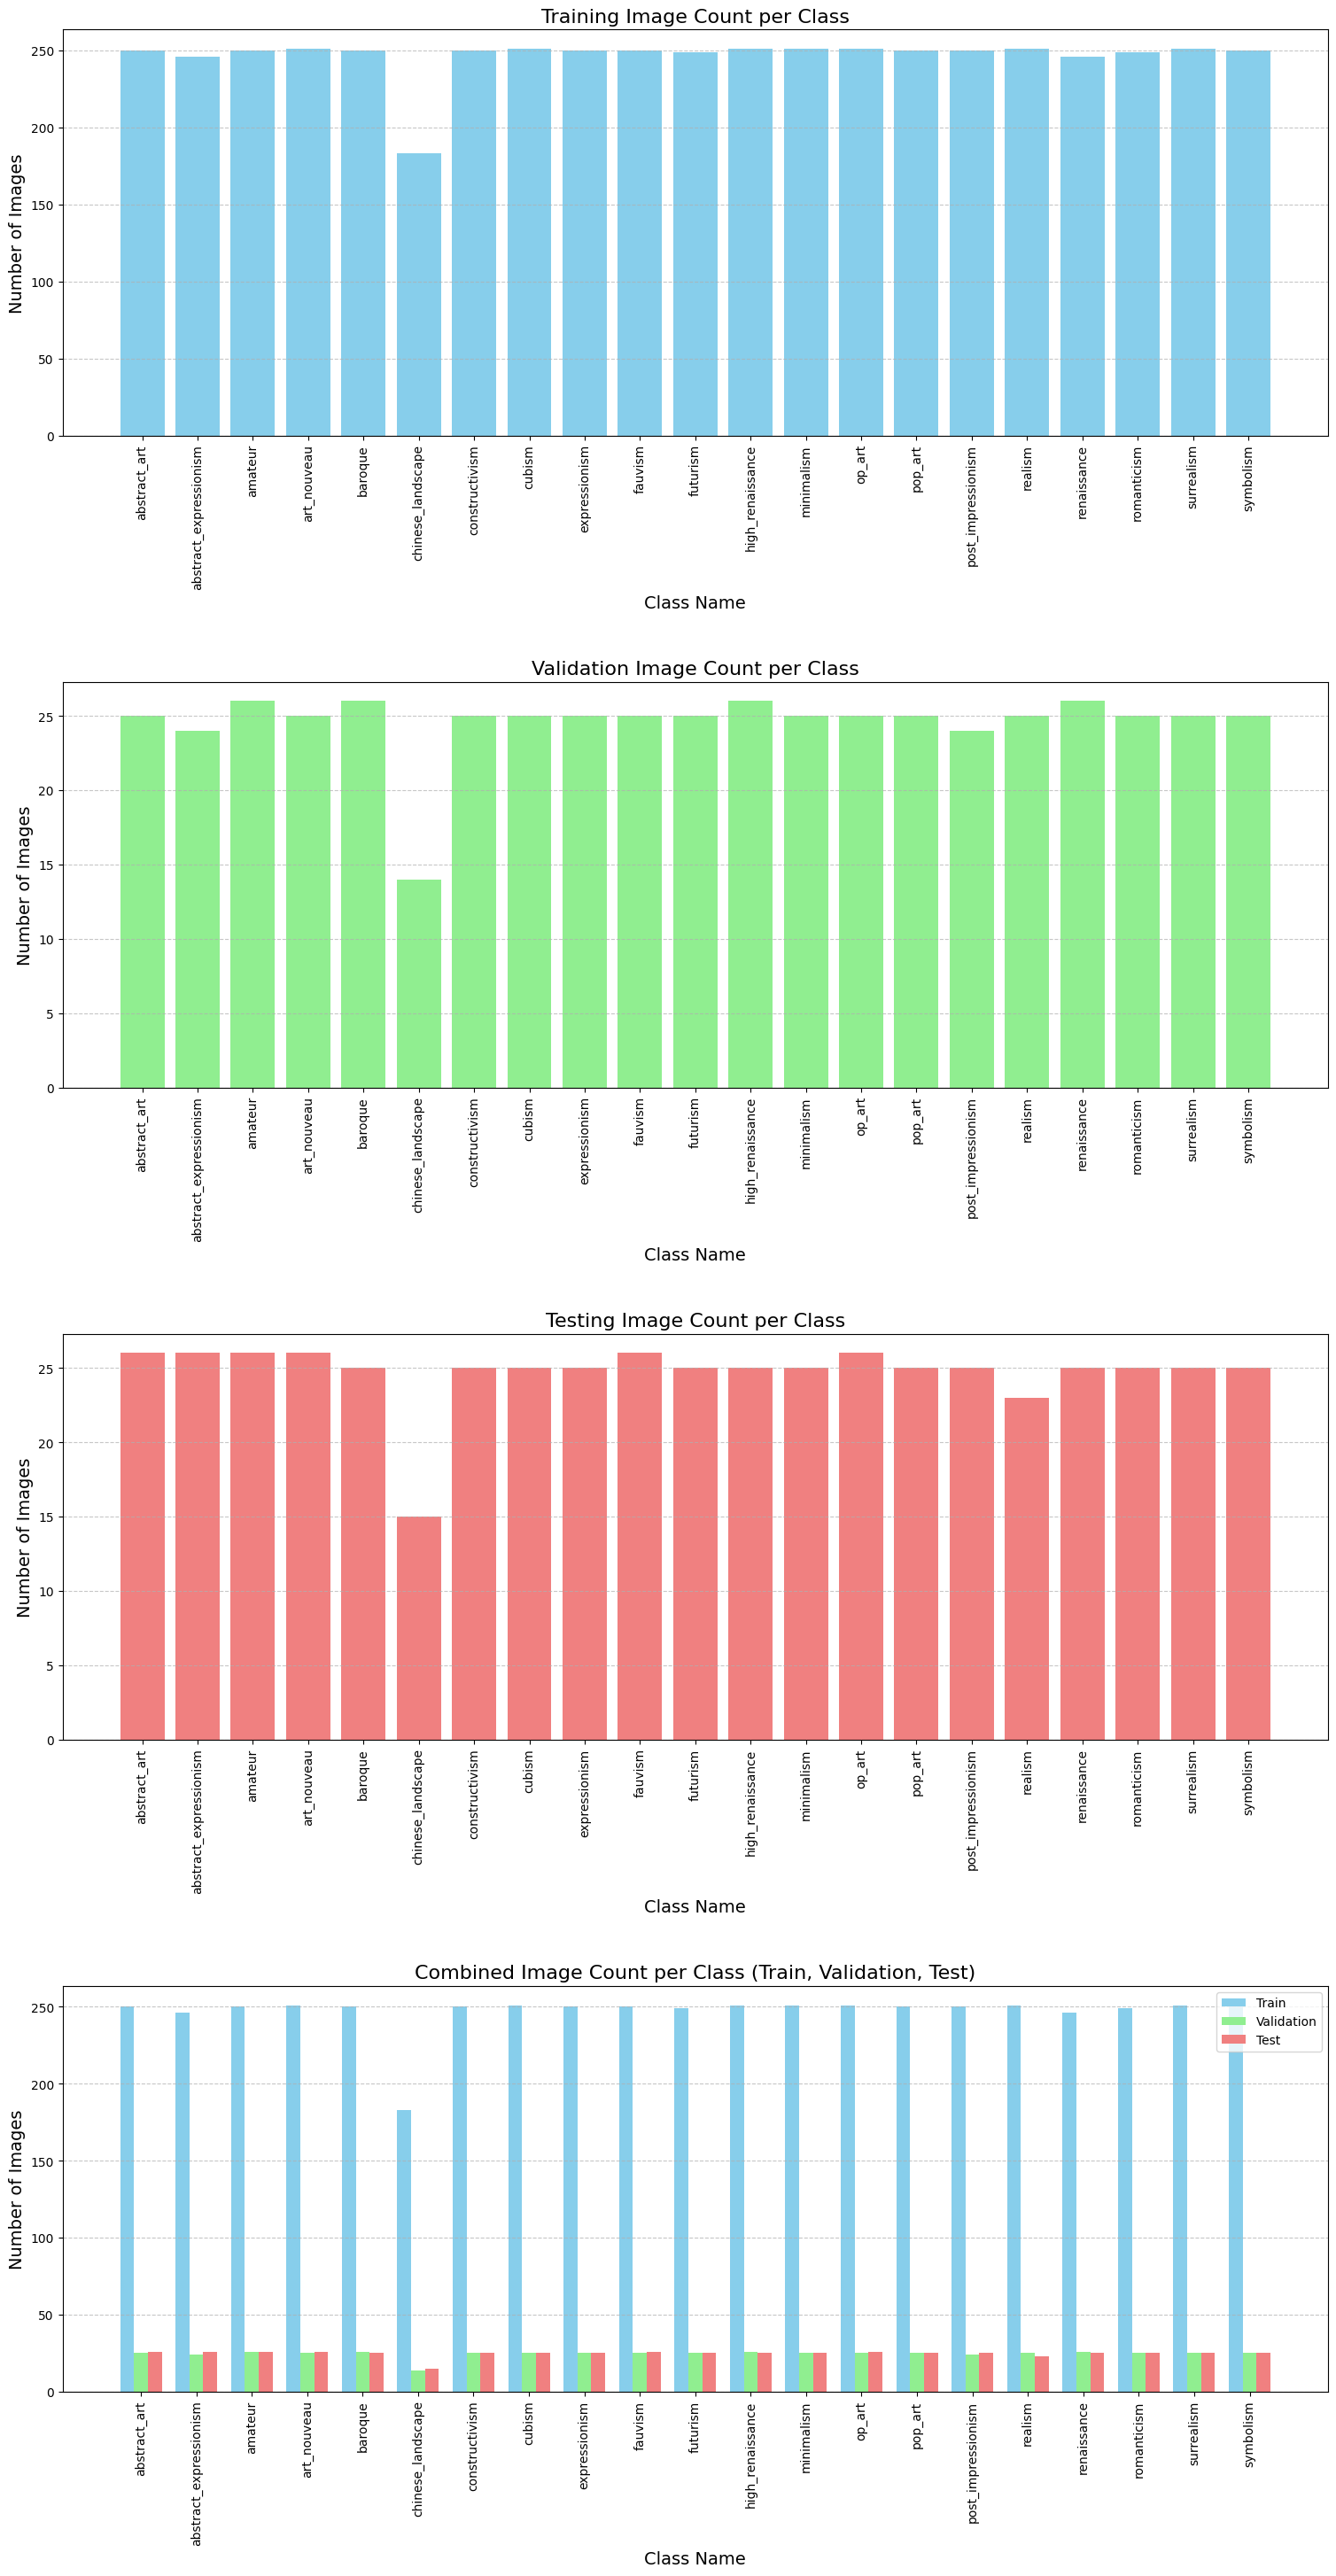

In [3]:
import os
import matplotlib.pyplot as plt
from torchvision import datasets

# Define dataset path
dataset_path = "/content/MerakiNexus-V2/art_classification_model/dataset"  # Update path if needed

# Load datasets
train_dataset = datasets.ImageFolder(root=f"{dataset_path}/train")
val_dataset = datasets.ImageFolder(root=f"{dataset_path}/val")
test_dataset = datasets.ImageFolder(root=f"{dataset_path}/test")

# Get class names and initialize counters
class_names = train_dataset.classes
train_image_counts, val_image_counts, test_image_counts = [], [], []

# Count images per class
for class_name in class_names:
    train_count = len(os.listdir(os.path.join(train_dataset.root, class_name)))
    val_count = len(os.listdir(os.path.join(val_dataset.root, class_name)))
    test_count = len(os.listdir(os.path.join(test_dataset.root, class_name)))

    train_image_counts.append(train_count)
    val_image_counts.append(val_count)
    test_image_counts.append(test_count)

# Create vertically stacked subplots
fig, axes = plt.subplots(4, 1, figsize=(16, 30))  # Wider + taller for readability

# Common x-axis style
def style_x_axis(ax):
    ax.set_xticks(range(len(class_names)))
    ax.set_xticklabels(class_names, rotation=90, fontsize=10)
    ax.set_xlabel("Class Name", fontsize=14)
    ax.set_ylabel("Number of Images", fontsize=14)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

# Training set plot
axes[0].bar(range(len(class_names)), train_image_counts, color='skyblue')
axes[0].set_title('Training Image Count per Class', fontsize=16)
style_x_axis(axes[0])

# Validation set plot
axes[1].bar(range(len(class_names)), val_image_counts, color='lightgreen')
axes[1].set_title('Validation Image Count per Class', fontsize=16)
style_x_axis(axes[1])

# Test set plot
axes[2].bar(range(len(class_names)), test_image_counts, color='lightcoral')
axes[2].set_title('Testing Image Count per Class', fontsize=16)
style_x_axis(axes[2])

# Combined view with grouped bars
bar_width = 0.25
x = list(range(len(class_names)))

axes[3].bar([i - bar_width for i in x], train_image_counts, width=bar_width, label='Train', color='skyblue')
axes[3].bar(x, val_image_counts, width=bar_width, label='Validation', color='lightgreen')
axes[3].bar([i + bar_width for i in x], test_image_counts, width=bar_width, label='Test', color='lightcoral')

axes[3].set_title('Combined Image Count per Class (Train, Validation, Test)', fontsize=16)
axes[3].set_xticks(x)
axes[3].set_xticklabels(class_names, rotation=90, fontsize=10)
axes[3].set_xlabel("Class Name", fontsize=14)
axes[3].set_ylabel("Number of Images", fontsize=14)
axes[3].legend()
axes[3].grid(axis='y', linestyle='--', alpha=0.7)

# Final layout adjustments
plt.tight_layout(pad=4)
plt.show()


| **Hyperparameter**        | **Value**                                                                          | **Description**                                            |
| ------------------------- | ---------------------------------------------------------------------------------- | ---------------------------------------------------------- |
| **Model Architecture**    | `alexnet`                                                                          | Pretrained AlexNet from `torchvision.models`               |
| **Input Image Size**      | `224 x 224`                                                                        | Required input size for AlexNet                            |
| **Batch Size**            | `64`                                                                               | Number of samples per mini-batch                           |
| **Epochs**                | `25`                                                                               | Total number of training epochs                            |
| **Learning Rate**         | `1e-4` (0.0001)                                                                    | Initial learning rate for the optimizer                    |
| **Optimizer**             | `Adam`                                                                             | Optimizer used for training the model                      |
| **Weight Decay**          | `1e-5` (0.00001)                                                                   | L2 regularization to prevent overfitting                   |
| **Loss Function**         | `CrossEntropyLoss`                                                                 | Standard classification loss function                      |
| **Data Augmentation**     | `Resize(224x224)`, `RandomHorizontalFlip`,<br>`RandomRotation(10°)`, `ColorJitter` | Increases dataset variability and generalization           |
| **Normalization Mean**    | `[0.485, 0.456, 0.406]`                                                            | ImageNet normalization mean values                         |
| **Normalization Std Dev** | `[0.229, 0.224, 0.225]`                                                            | ImageNet normalization std values                          |
| **Dropout (Head Layer)**  | `0.5` (first), `0.3` (second)                                                      | Applied before classification layers to reduce overfitting |
| **Intermediate FC Layer** | `512 units + ReLU + BatchNorm1d`                                                   | Custom head for learning representation before output      |
| **Target Classes**        | `11`                                                                               | Number of output classes (art styles)                      |
| **Feature Extractor**     | `Frozen`                                                                           | Only classifier head is trainable                          |
| **Evaluation Metric**     | `Accuracy`, `Precision`, `Recall`, `F1`                                            | Metrics computed on test set                               |
| **Device**                | `CUDA` if available, else `CPU`                                                    | Runs on GPU if available                                   |


Train samples: 5168 | Val samples: 512 | Test samples: 511


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 186MB/s]



Starting Training...



Epoch 1/25 Training: 100%|██████████| 81/81 [00:56<00:00,  1.44it/s, loss=2.07]


Epoch 1 Completed | Train Loss: 2.4316 | Val Loss: 2.0176 | Val Acc: 38.67% | Time: 61.58s


Epoch 2/25 Training: 100%|██████████| 81/81 [00:54<00:00,  1.48it/s, loss=1.72]


Epoch 2 Completed | Train Loss: 1.8059 | Val Loss: 1.8853 | Val Acc: 44.34% | Time: 60.15s


Epoch 3/25 Training: 100%|██████████| 81/81 [00:53<00:00,  1.50it/s, loss=1.82]


Epoch 3 Completed | Train Loss: 1.5559 | Val Loss: 1.7782 | Val Acc: 45.31% | Time: 59.30s


Epoch 4/25 Training: 100%|██████████| 81/81 [00:53<00:00,  1.50it/s, loss=1.56]


Epoch 4 Completed | Train Loss: 1.3873 | Val Loss: 1.6979 | Val Acc: 49.41% | Time: 58.58s


Epoch 5/25 Training: 100%|██████████| 81/81 [00:54<00:00,  1.48it/s, loss=1.25]


Epoch 5 Completed | Train Loss: 1.2303 | Val Loss: 1.6402 | Val Acc: 51.95% | Time: 59.16s


Epoch 6/25 Training: 100%|██████████| 81/81 [00:54<00:00,  1.50it/s, loss=1.42]


Epoch 6 Completed | Train Loss: 1.1269 | Val Loss: 1.5856 | Val Acc: 52.93% | Time: 58.76s


Epoch 7/25 Training: 100%|██████████| 81/81 [00:53<00:00,  1.52it/s, loss=1.26]


Epoch 7 Completed | Train Loss: 1.0112 | Val Loss: 1.5117 | Val Acc: 55.86% | Time: 58.39s


Epoch 8/25 Training: 100%|██████████| 81/81 [00:53<00:00,  1.52it/s, loss=0.939]


Epoch 8 Completed | Train Loss: 0.9079 | Val Loss: 1.5609 | Val Acc: 53.91% | Time: 58.59s


Epoch 9/25 Training: 100%|██████████| 81/81 [00:52<00:00,  1.53it/s, loss=0.967]


Epoch 9 Completed | Train Loss: 0.8454 | Val Loss: 1.5218 | Val Acc: 55.86% | Time: 57.55s


Epoch 10/25 Training: 100%|██████████| 81/81 [00:54<00:00,  1.50it/s, loss=0.827]


Epoch 10 Completed | Train Loss: 0.7570 | Val Loss: 1.5647 | Val Acc: 55.27% | Time: 58.52s


Epoch 11/25 Training: 100%|██████████| 81/81 [00:53<00:00,  1.50it/s, loss=0.882]


Epoch 11 Completed | Train Loss: 0.6586 | Val Loss: 1.5005 | Val Acc: 57.62% | Time: 58.35s


Epoch 12/25 Training: 100%|██████████| 81/81 [00:52<00:00,  1.53it/s, loss=0.566]


Epoch 12 Completed | Train Loss: 0.6061 | Val Loss: 1.4787 | Val Acc: 57.23% | Time: 58.24s


Epoch 13/25 Training: 100%|██████████| 81/81 [00:53<00:00,  1.52it/s, loss=0.497]


Epoch 13 Completed | Train Loss: 0.5446 | Val Loss: 1.5248 | Val Acc: 56.84% | Time: 58.16s


Epoch 14/25 Training: 100%|██████████| 81/81 [00:53<00:00,  1.52it/s, loss=0.365]


Epoch 14 Completed | Train Loss: 0.5065 | Val Loss: 1.5424 | Val Acc: 55.08% | Time: 57.84s


Epoch 15/25 Training: 100%|██████████| 81/81 [00:53<00:00,  1.50it/s, loss=0.543]


Epoch 15 Completed | Train Loss: 0.4668 | Val Loss: 1.5072 | Val Acc: 58.01% | Time: 58.54s


Epoch 16/25 Training: 100%|██████████| 81/81 [00:53<00:00,  1.51it/s, loss=0.591]


Epoch 16 Completed | Train Loss: 0.4219 | Val Loss: 1.4863 | Val Acc: 57.23% | Time: 59.09s


Epoch 17/25 Training: 100%|██████████| 81/81 [00:53<00:00,  1.51it/s, loss=0.28]


Epoch 17 Completed | Train Loss: 0.3813 | Val Loss: 1.5218 | Val Acc: 56.84% | Time: 59.07s


Epoch 18/25 Training: 100%|██████████| 81/81 [00:53<00:00,  1.50it/s, loss=0.522]


Epoch 18 Completed | Train Loss: 0.3615 | Val Loss: 1.5919 | Val Acc: 55.08% | Time: 58.92s


Epoch 19/25 Training: 100%|██████████| 81/81 [00:54<00:00,  1.49it/s, loss=0.243]


Epoch 19 Completed | Train Loss: 0.3150 | Val Loss: 1.5476 | Val Acc: 57.23% | Time: 58.99s


Epoch 20/25 Training: 100%|██████████| 81/81 [00:54<00:00,  1.47it/s, loss=0.431]


Epoch 20 Completed | Train Loss: 0.3036 | Val Loss: 1.5884 | Val Acc: 58.79% | Time: 59.53s


Epoch 21/25 Training: 100%|██████████| 81/81 [00:54<00:00,  1.49it/s, loss=0.261]


Epoch 21 Completed | Train Loss: 0.2828 | Val Loss: 1.6848 | Val Acc: 56.05% | Time: 59.11s


Epoch 22/25 Training: 100%|██████████| 81/81 [00:54<00:00,  1.49it/s, loss=0.15]


Epoch 22 Completed | Train Loss: 0.2560 | Val Loss: 1.6257 | Val Acc: 57.62% | Time: 59.36s


Epoch 23/25 Training: 100%|██████████| 81/81 [00:54<00:00,  1.50it/s, loss=0.356]


Epoch 23 Completed | Train Loss: 0.2478 | Val Loss: 1.5587 | Val Acc: 58.01% | Time: 59.55s


Epoch 24/25 Training: 100%|██████████| 81/81 [00:53<00:00,  1.51it/s, loss=0.219]


Epoch 24 Completed | Train Loss: 0.2287 | Val Loss: 1.4921 | Val Acc: 58.40% | Time: 59.05s


Epoch 25/25 Training: 100%|██████████| 81/81 [00:53<00:00,  1.50it/s, loss=0.352]


Epoch 25 Completed | Train Loss: 0.2267 | Val Loss: 1.5633 | Val Acc: 57.03% | Time: 58.62s

Total Training Time: 1473.01s (24.55 minutes)


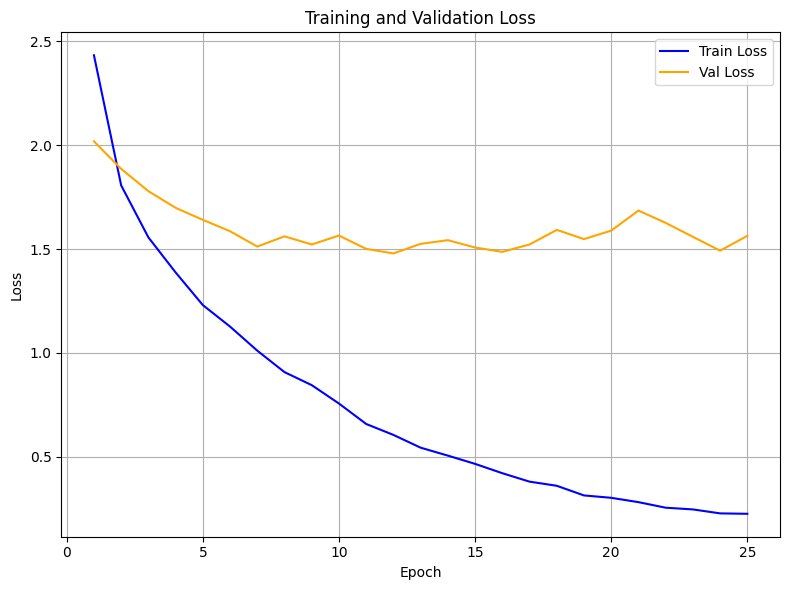

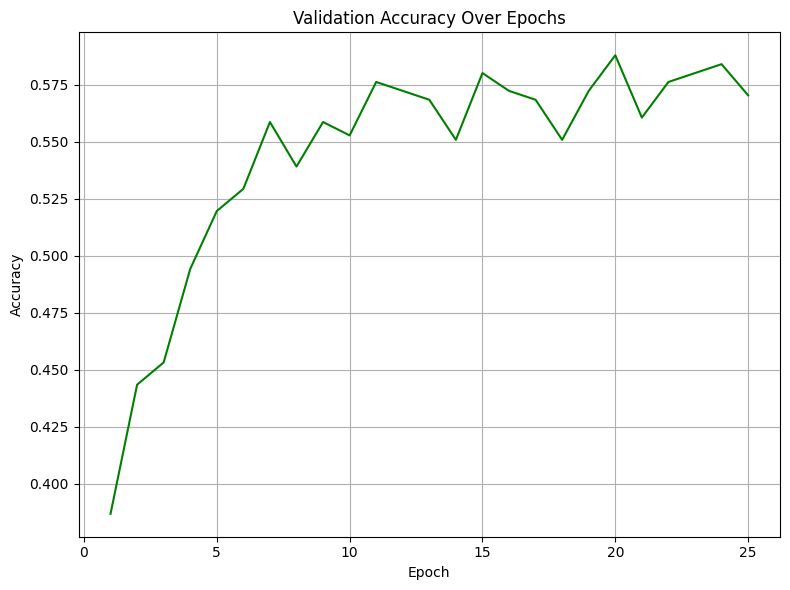

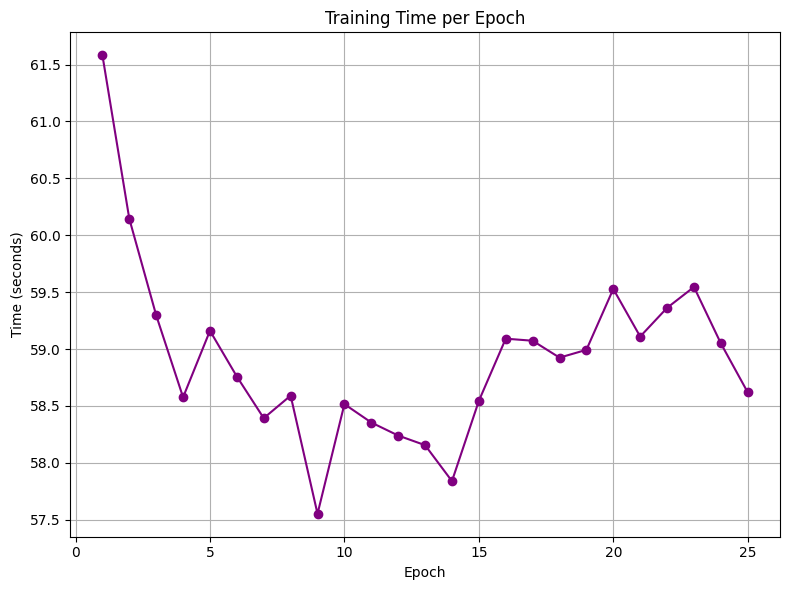


Test Accuracy: 55.97%

Precision, Recall, F1-Score Table:

                        precision  recall  f1-score
abstract_art                0.435   0.400     0.417
abstract_expressionism      0.524   0.440     0.478
amateur                     0.440   0.440     0.440
art_nouveau                 0.407   0.440     0.423
baroque                     0.613   0.792     0.691
chinese_landscape           0.667   1.000     0.800
constructivism              0.375   0.360     0.367
cubism                      0.476   0.400     0.435
expressionism               0.545   0.480     0.511
fauvism                     0.476   0.400     0.435
futurism                    0.500   0.440     0.468
high_renaissance            0.667   0.560     0.609
minimalism                  0.733   0.880     0.800
op_art                      0.630   0.680     0.654
pop_art                     0.652   0.600     0.625
post_impressionism          0.407   0.440     0.423
realism                     0.714   0.652     0.682
rena

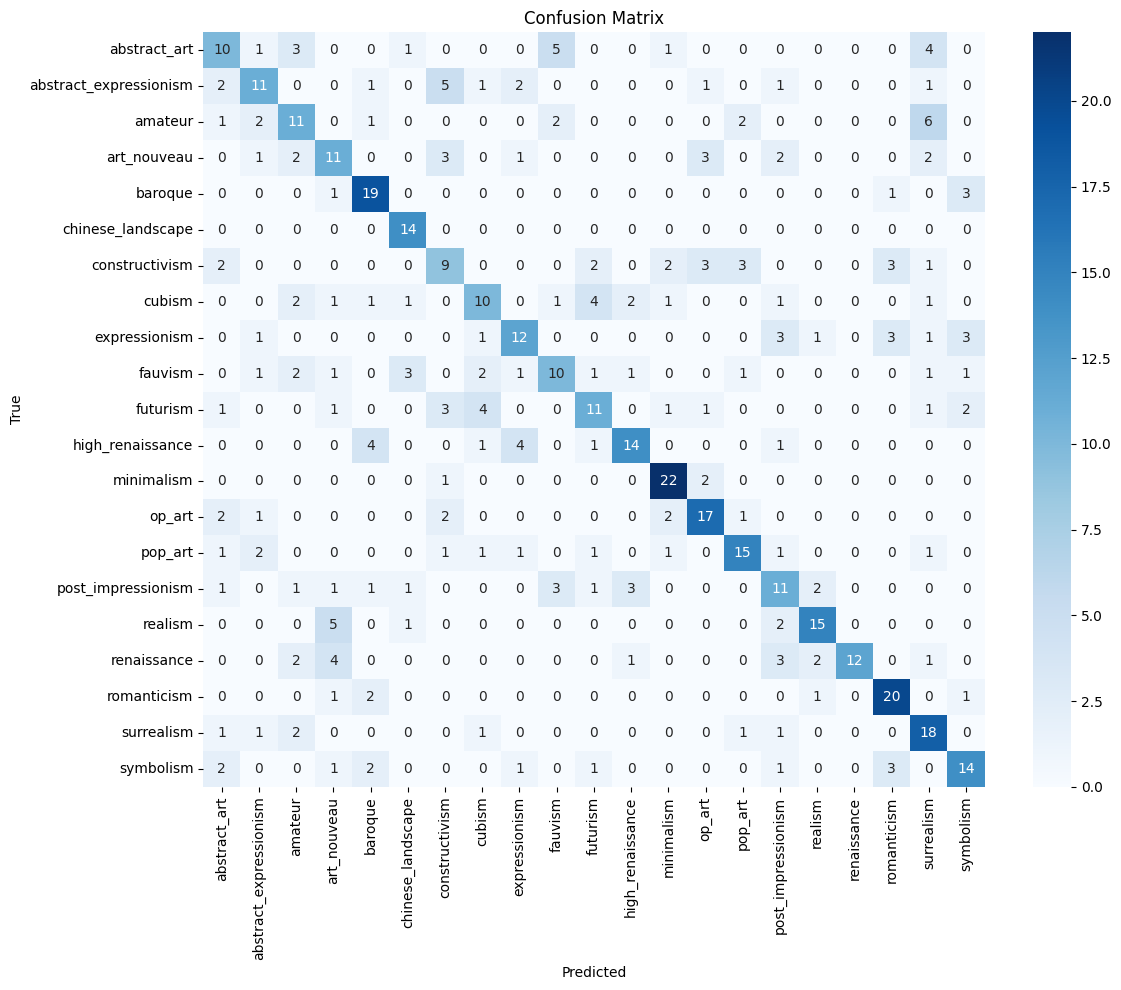

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pandas as pd
from tqdm import tqdm
import time

# ======== Device Configuration ========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ======== Data Transforms (AlexNet expects 224x224 input) ========
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# ======== Dataset and DataLoaders ========
dataset_path = "/content/MerakiNexus-V2/art_classification_model/dataset"
train_data = datasets.ImageFolder(root=f"{dataset_path}/train", transform=transform)
val_data = datasets.ImageFolder(root=f"{dataset_path}/val", transform=transform)
test_data = datasets.ImageFolder(root=f"{dataset_path}/test", transform=transform)

print(f"Train samples: {len(train_data)} | Val samples: {len(val_data)} | Test samples: {len(test_data)}")

batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# ======== AlexNet Model Definition ========
class ArtworkClassificationAlexNet(nn.Module):
    def __init__(self, num_classes=11):
        super(ArtworkClassificationAlexNet, self).__init__()
        self.model = models.alexnet(pretrained=True)

        # Freeze feature extractor
        for param in self.model.features.parameters():
            param.requires_grad = False

        # Replace classifier
        in_features = self.model.classifier[6].in_features
        self.model.classifier[6] = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.model(x)

model = ArtworkClassificationAlexNet(num_classes=len(train_data.classes)).to(device)

# ======== Loss Function and Optimizer ========
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

# ======== Training Loop ========
num_epochs = 25
train_losses = []
val_losses = []
val_accuracies = []
epoch_times = []

print("\nStarting Training...\n")
for epoch in range(num_epochs):
    epoch_start = time.time()
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Training") as tepoch:
        for images, labels in tepoch:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            tepoch.set_postfix(loss=loss.item())

    train_loss_epoch = running_loss / len(train_loader)
    train_accuracy = correct / total
    train_losses.append(train_loss_epoch)

    # ======== Validation ========
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = outputs.argmax(dim=1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    val_loss_epoch = val_loss / len(val_loader)
    val_accuracy = correct_val / total_val
    val_losses.append(val_loss_epoch)
    val_accuracies.append(val_accuracy)

    epoch_duration = time.time() - epoch_start
    epoch_times.append(epoch_duration)

    print(f"Epoch {epoch+1} Completed | Train Loss: {train_loss_epoch:.4f} | Val Loss: {val_loss_epoch:.4f} | Val Acc: {val_accuracy*100:.2f}% | Time: {epoch_duration:.2f}s")

total_training_time = sum(epoch_times)
print(f"\nTotal Training Time: {total_training_time:.2f}s ({total_training_time/60:.2f} minutes)")

# ======== Plotting ========
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss", color='blue')
plt.plot(range(1, num_epochs+1), val_losses, label="Val Loss", color='orange')
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs+1), val_accuracies, label="Val Accuracy", color='green')
plt.title("Validation Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs+1), epoch_times, marker='o', color='purple')
plt.title("Training Time per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Time (seconds)")
plt.grid(True)
plt.tight_layout()
plt.show()

# ======== Evaluation on Test Set ========
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"\nTest Accuracy: {accuracy * 100:.2f}%")

# ======== Classification Report & Confusion Matrix ========
report = classification_report(all_labels, all_preds, target_names=train_data.classes, output_dict=True)
df_report = pd.DataFrame(report).transpose()

print("\nPrecision, Recall, F1-Score Table:\n")
print(df_report[['precision', 'recall', 'f1-score']].round(3))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_data.classes,
            yticklabels=train_data.classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


In [5]:
scripted_model = torch.jit.script(model)  # Convert to TorchScript

# Save the TorchScript model to a file
torch.jit.save(scripted_model, "/content/artwork_classification_model_subject_2_AlexNet.pth");


✅ Test Accuracy: 55.58%

📊 Classification Report (per class):

                        precision  recall  f1-score
abstract_art                0.409   0.360     0.383
abstract_expressionism      0.429   0.360     0.391
amateur                     0.545   0.480     0.511
art_nouveau                 0.409   0.360     0.383
baroque                     0.576   0.792     0.667
chinese_landscape           0.700   1.000     0.824
constructivism              0.480   0.480     0.480
cubism                      0.545   0.480     0.511
expressionism               0.533   0.320     0.400
fauvism                     0.429   0.360     0.391
futurism                    0.500   0.320     0.390
high_renaissance            0.750   0.600     0.667
minimalism                  0.821   0.920     0.868
op_art                      0.571   0.640     0.604
pop_art                     0.462   0.720     0.562
post_impressionism          0.467   0.560     0.509
realism                     0.565   0.565     0.565


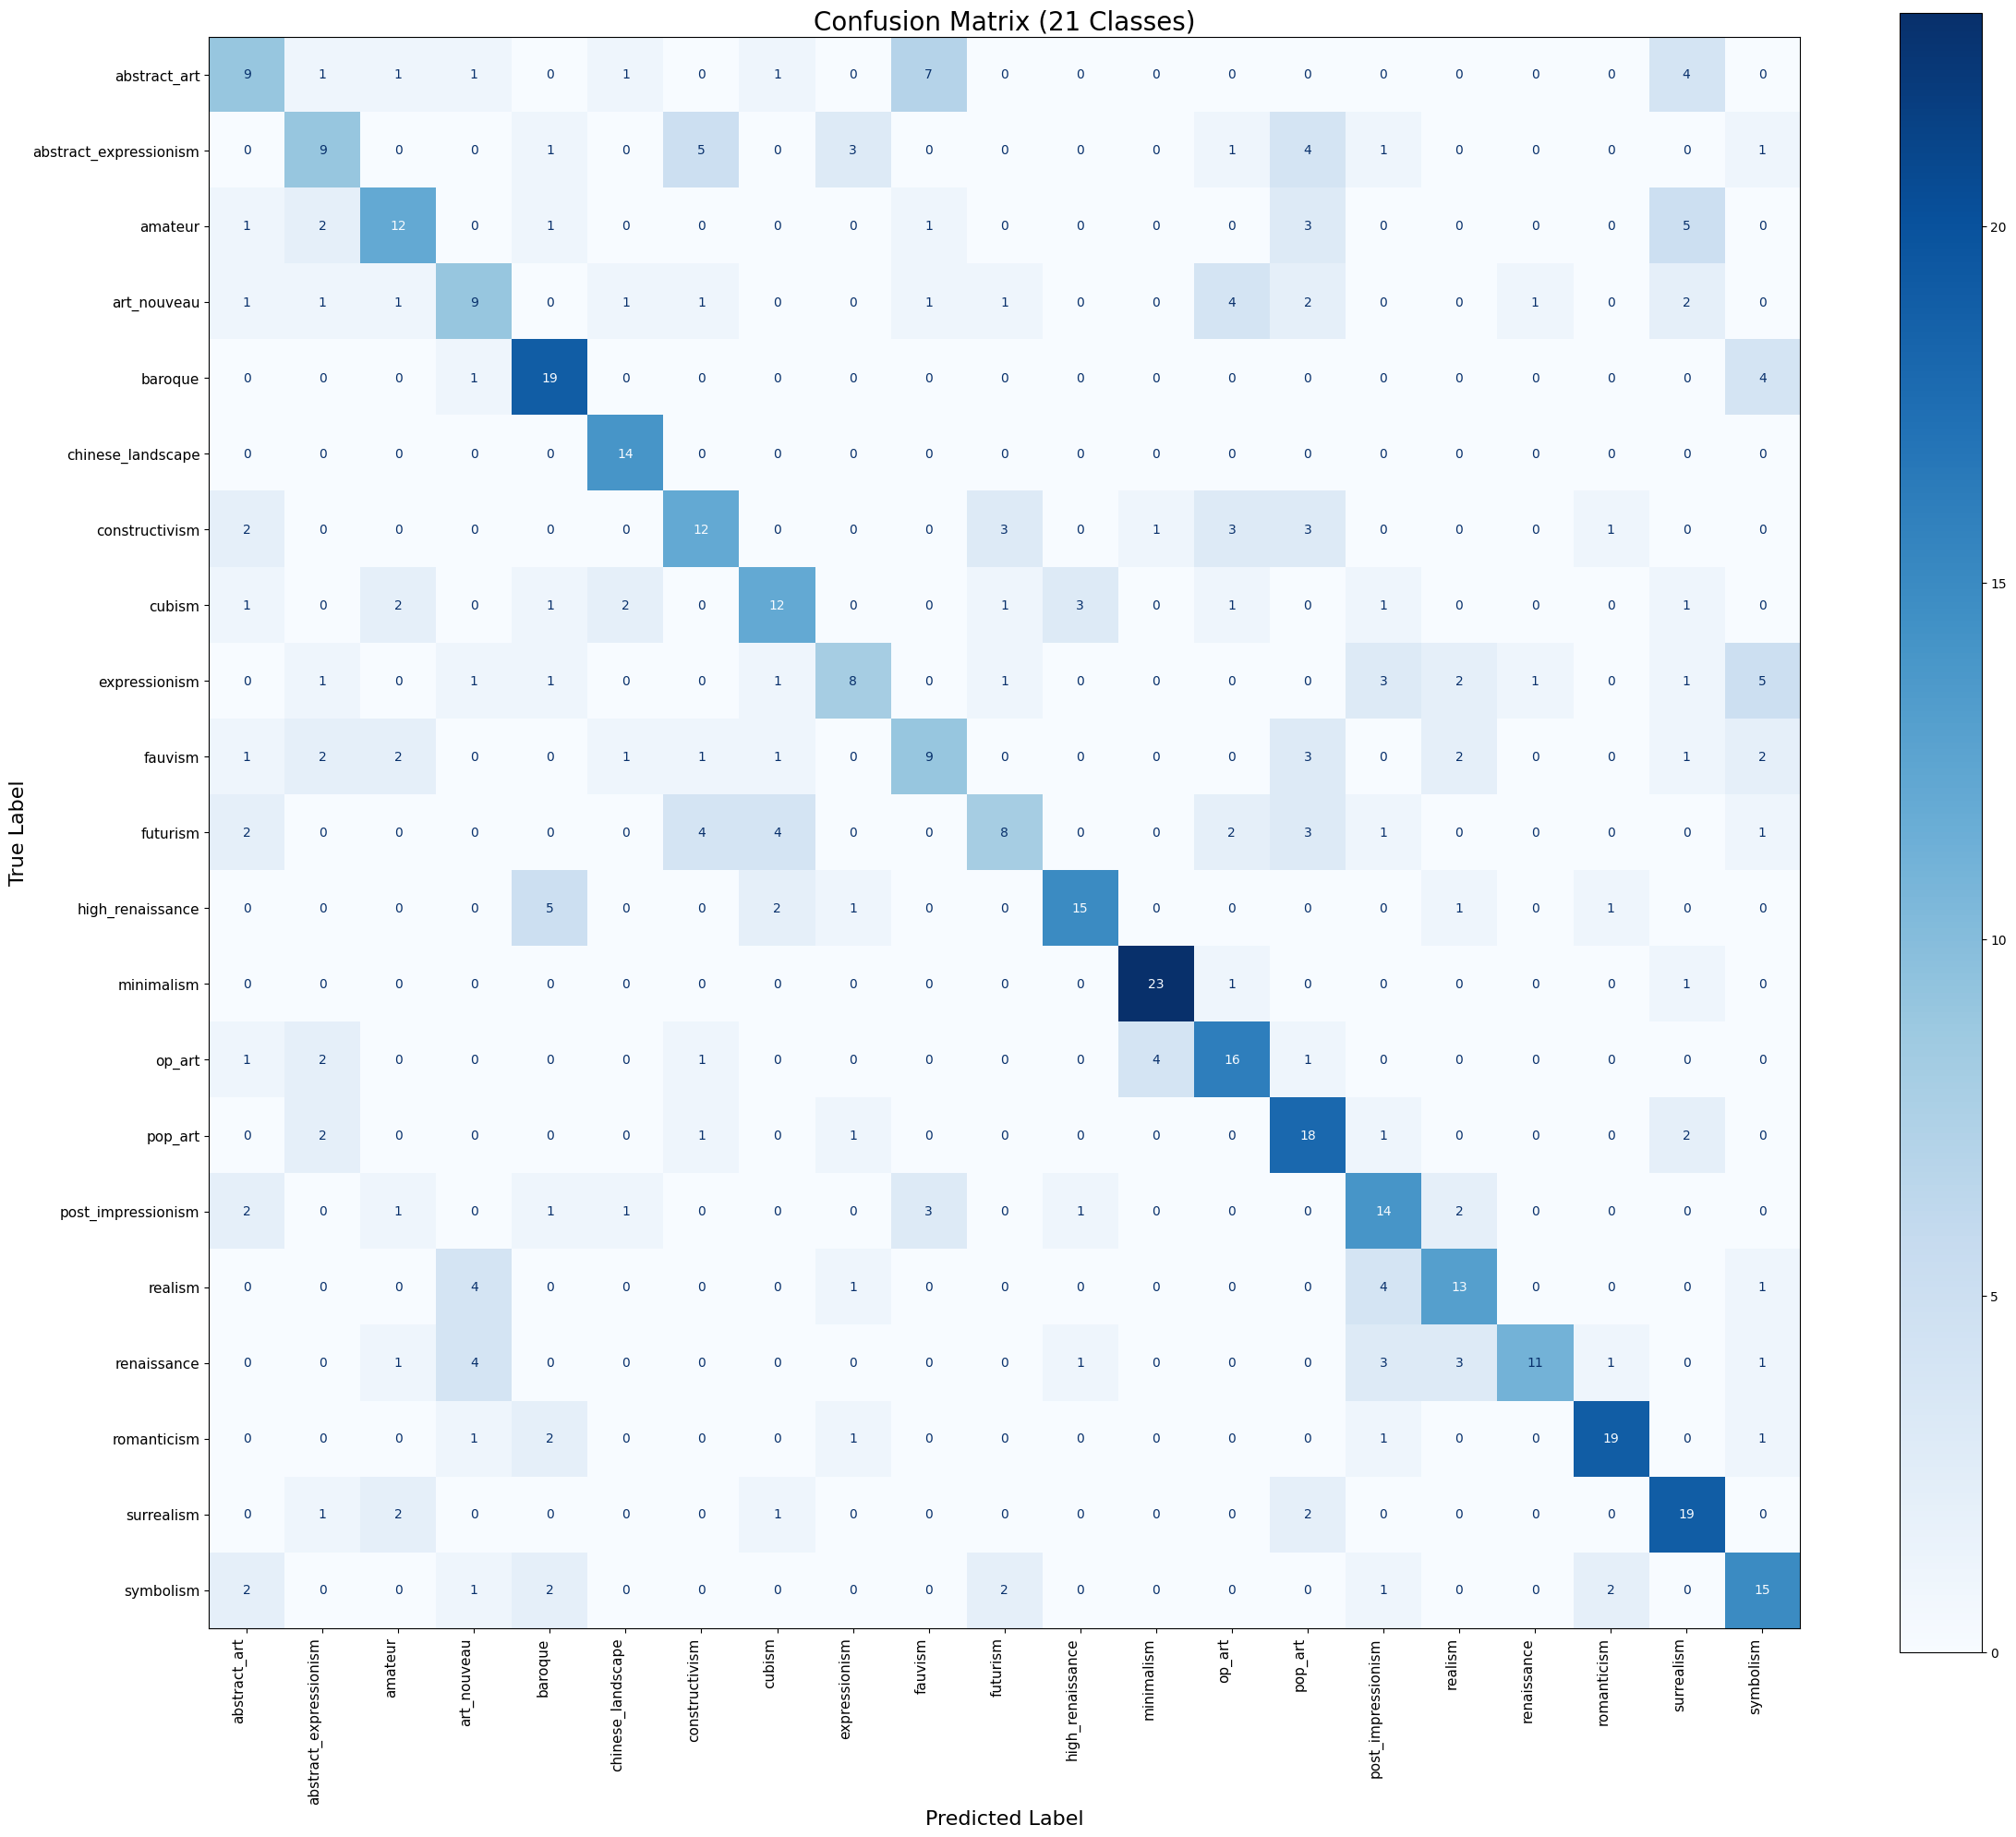

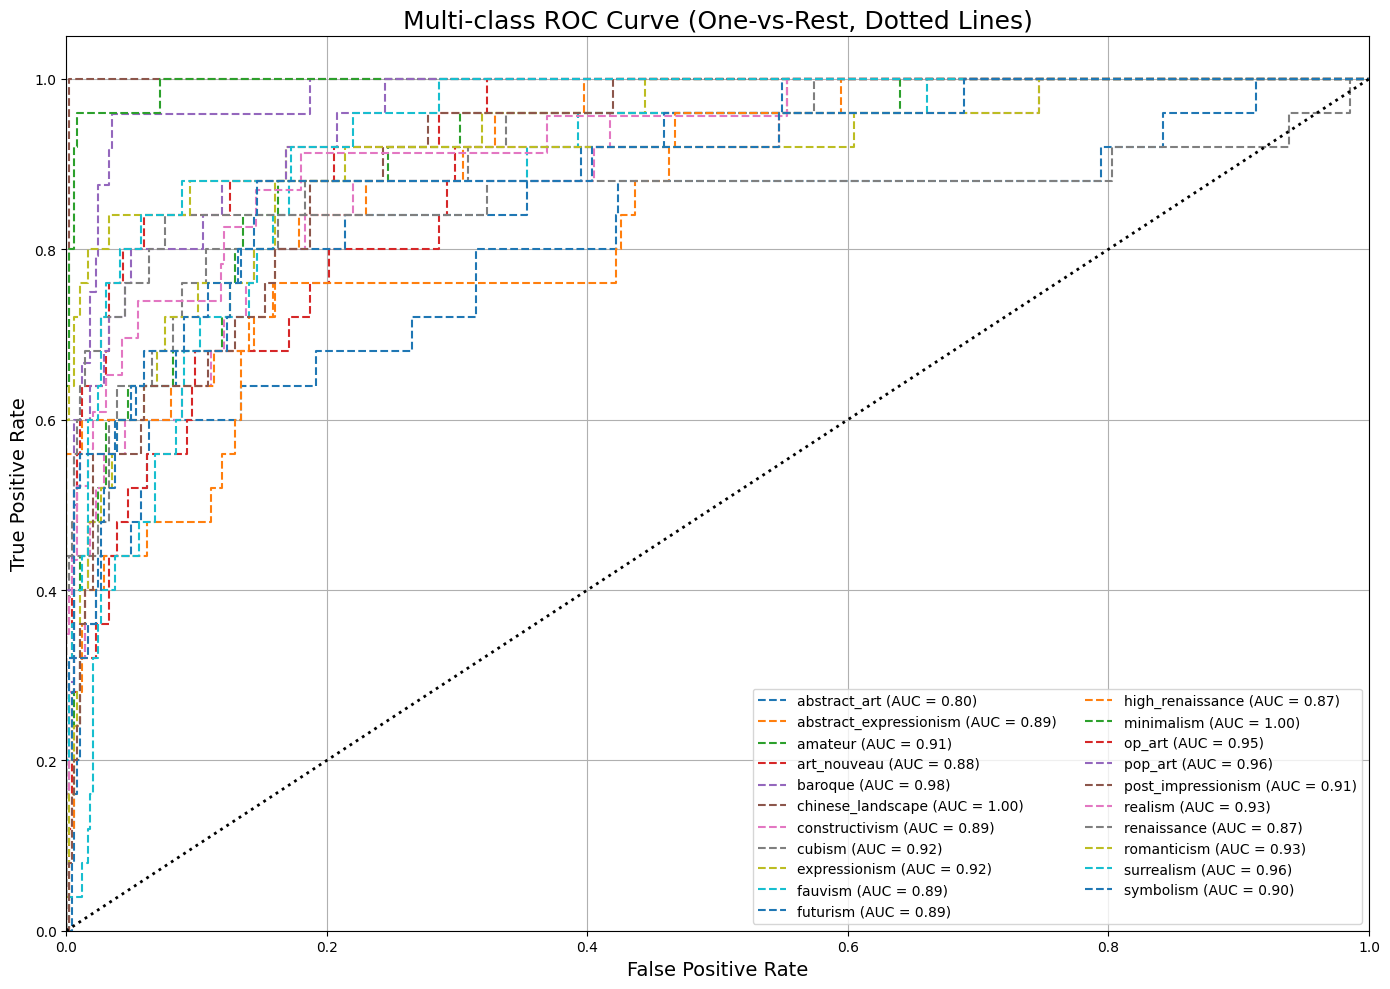

In [6]:
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc
)
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import label_binarize

# ========== Define transforms ==========
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# ========== Load the test dataset ==========
test_dataset = datasets.ImageFolder(
    '/content/MerakiNexus-V2/art_classification_model/dataset/test',
    transform=transform
)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
class_names = test_dataset.classes
num_classes = len(class_names)

# ========== Load TorchScript model ==========
scripted_model = torch.jit.load("/content/artwork_classification_model_subject_2_AlexNet.pth")
scripted_model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
scripted_model.to(device)

# ========== Evaluation on Test Set ==========
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = scripted_model(images)
        probs = F.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# ========== Overall Test Accuracy ==========
test_accuracy = accuracy_score(all_labels, all_preds)
print(f"\n✅ Test Accuracy: {test_accuracy * 100:.2f}%")

# ========== Precision, Recall, F1-Score ==========
report = classification_report(
    all_labels,
    all_preds,
    target_names=class_names,
    digits=3,
    output_dict=True
)
df_metrics = pd.DataFrame(report).transpose()
print("\n📊 Classification Report (per class):\n")
print(df_metrics[['precision', 'recall', 'f1-score']].round(3))

# Optional: Save report as CSV
# df_metrics.to_csv("classification_metrics_test.csv")

# ========== Confusion Matrix ==========
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(24, 20))
disp.plot(
    cmap="Blues",
    values_format='d',
    ax=ax
)

plt.setp(ax.get_xticklabels(), rotation=90, ha='right', fontsize=11)
plt.setp(ax.get_yticklabels(), fontsize=11)
ax.set_title("Confusion Matrix (21 Classes)", fontsize=20)
ax.set_xlabel("Predicted Label", fontsize=16)
ax.set_ylabel("True Label", fontsize=16)
plt.tight_layout()
plt.show()

# ========== ROC Curve ==========
# Binarize labels
y_true_bin = label_binarize(all_labels, classes=list(range(num_classes)))
y_score = np.array(all_probs)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class as dotted lines
plt.figure(figsize=(14, 10))
for i in range(num_classes):
    plt.plot(
        fpr[i],
        tpr[i],
        linestyle='--',
        lw=1.5,
        label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})"
    )

plt.plot([0, 1], [0, 1], 'k:', lw=2)  # Diagonal reference line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.title("Multi-class ROC Curve (One-vs-Rest, Dotted Lines)", fontsize=18)
plt.legend(loc="lower right", fontsize=10, ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()
